# Donor match

In this notebook, we align donors (after running `cellSNP` and `vireo` without any genotype) by their genotypes. Specifically we are aligning the donor genotypes estimated with vireo from the scRNA-seq data with other the genotypes coming from other 'omics data (e.g., SNP array, Exome-seq). The idea is that we align the donors with giving least genotype difference, either using categorical genotype value or genotype probability.

To do so 

1. First run cellSNP to genotype the barcodes in the scRNA-seq libaries and make a .vcf file with the varians in their reads (CellGen can do this for you, is computational expensive):

```
cellSNP -s sample.bam -b sample.barcodes.tsv -o out.sample.cellsnp -R genome1K.phase3.SNP_AF5e2.chr1toX.hg38.vcf.gz -p 6 --minMAF 0.1 --minCOUNT 20
```

> Find `genome1K.phase3.SNP_AF5e2.chr1toX.hg38.vcf.gz` here https://sourceforge.net/projects/cellsnp/files/SNPlist/

2. Next run vireo without any genotype. This uses the SNPs in the previous step to classify scRNA-seq barcodes and the variants into `N` donors, and generate a .vcf with the variants of each donor:

```
vireo -c sample/cellSNP-out/ -N 2 -o out/sample/ -t GT
```

3. Use the code below will link the donor's genotype from step 2 (i.e. donors and genotypes estimated from scRNA-seq) with the genotypes provided from SNP array/Exome-seq data.

> IMPORTANT: the .vcf file from SNP array/Exome-seq data should only contain SNPs. Missing values (./.) should be removed. 
You can use `bcftools  view -g ^miss in.vcf > out.vcf` to filter missing values


In [1]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import vireoSNP
print("vireoSNP version: %s" %vireoSNP.__version__)


def getdataframe(res, library_id):
    # What to make the function do
    
    df = pd.DataFrame(res['matched_GPb_diff'],
                 index=res['matched_donors1'],
                 columns=res['matched_donors2'])
    df['Patient'] = df.index
    df['library'] = library_id
    results = pd.melt(df, id_vars = ['Patient', 'library'])
    return results


def match_donors(scRNAseq_libraries, genotype_vcf):
    for library_id in scRNAseq_libraries:
        print(library_id)


        # Link donors
        res = vireoSNP.vcf.match_VCF_samples('/home/jovyan/vireo/out_novcf/'+library_id+'/GT_donors.vireo.vcf.gz', 
                                              genotype_vcf,
                                             GT_tag1 = 'GT', GT_tag2='GT')


        # Save data frame
        results = getdataframe(res, library_id)
        results.to_csv('~/vireo/donor_assignements/'+library_id+'_donor_assignement.csv')


        # Plot
        fig = plt.figure()
        vireoSNP.plot.heat_matrix(res['matched_GPb_diff'], 
                                  res['matched_donors1'] , 
                                  res['matched_donors2'] )
        plt.title("Geno Prob Delta: %d SNPs" %(res['matched_n_var']))
        plt.tight_layout()
        plt.show()

        fig = plt.figure()
        vireoSNP.plot.heat_matrix(res['matched_GPb_diff'] < 0.11, 
                                  res['matched_donors1'] , 
                                  res['matched_donors2'] )
        plt.title("Geno Prob Delta: %d SNPs" %(res['matched_n_var']))
        plt.tight_layout()
        plt.show()

vireoSNP version: 0.5.8


UA_Endo12269814
Shape for Geno Prob in VCF1: (206352, 2, 3)
Shape for Geno Prob in VCF2: (206352, 2, 3)
n_variants in VCF1, VCF2 and matched: 206352, 407928, 8102
aligned donors:
['donor0' 'donor1']
['EX0789' 'FX9009']


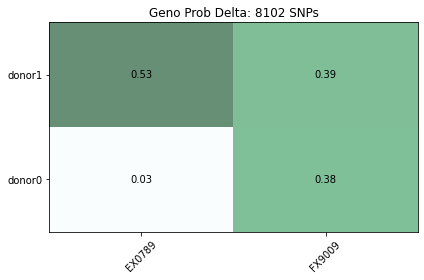

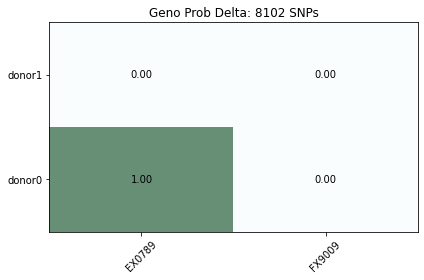

UA_Endo12269812
Shape for Geno Prob in VCF1: (126267, 2, 3)
Shape for Geno Prob in VCF2: (126267, 2, 3)
n_variants in VCF1, VCF2 and matched: 126267, 407928, 4937
aligned donors:
['donor0' 'donor1']
['EX0789' 'FX9009']


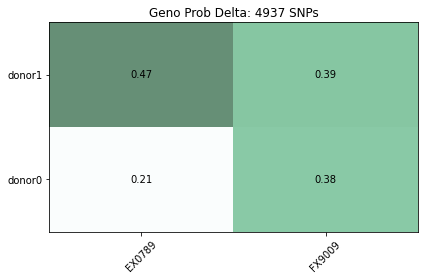

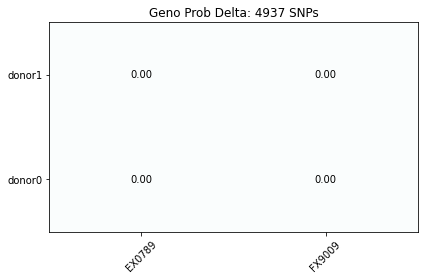

In [2]:
match_donors(scRNAseq_libraries=['UA_Endo12269814', 'UA_Endo12269812'], 
             genotype_vcf='/nfs/users/nfs_l/lg18/team292/lg18/endometriosis/data/genotypes/sample_specific_filtered/FX9009_EX0789.vcf')
#              genotype_vcf='/nfs/users/nfs_l/lg18/team292/lg18/endometriosis/data/genotypes/all_for_nuclei_deconvolution_extra_sample.renamed.fixed.vcf')